Convolutional Neural Network (CNN) implementation for Diabetic Retinopathy Detection 
https://www.kaggle.com/c/diabetic-retinopathy-detection/data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from cv2 import cv2
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

I have already downloaded the dataset from Kaggle.
I have noted all the steps to download the database in a seperate file.
Below I am loading a CSV file containing training labels 

In [3]:
df_train = pd.read_csv('/storage/trainLabels.csv')

Lets take a look at all the labels.
'10_left' is a name of the file whereas '0/1/2/3/4' are the labels
'10_left' image of the left eye
'10_right' image of the right eye for the same person

In [4]:
df_train.values

array([['10_left', 0],
       ['10_right', 0],
       ['13_left', 0],
       ...,
       ['44348_right', 0],
       ['44349_left', 0],
       ['44349_right', 1]], dtype=object)

There are 35125 images in the training set, 'level' is the column indicating the labels for its respective images

In [5]:
df_train.tail()

,image,level
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0
35125,44349_right,1


We will use Pandas to convert df_train into a series.
and get_dummies to do one hot encoding (FYI, I am not using one hot encoding during training as of now)

In [6]:
targets_series = pd.Series(df_train['level'])
one_hot = pd.get_dummies(targets_series, sparse = True)

As I said before there are 5 types of labels 0/1/2/3/4, thry are distinguished as below
NDPR - Non Proliferative Diabetic Retinopathy

Class	 Name
0	    Normal	
1	    Mild NPDR
2	    Moderate NPDR
3	    Severe NPDR	
4	    PDR

In [7]:
targets_series[:10]

0    0
1    0
2    0
3    0
4    1
5    2
6    4
7    4
8    0
9    1
Name: level, dtype: int64

In [8]:
one_hot[:10]

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,0,0,0,0,1
8,1,0,0,0,0
9,0,1,0,0,0


In [9]:
one_hot_labels = np.asarray(one_hot)

In [10]:
one_hot_labelsY = np.asarray(targets_series)

Lets take a look at the array containing just the labels

In [11]:
one_hot_labelsY[:10]

array([0, 0, 0, 0, 1, 2, 4, 4, 0, 1])

Some declarations

In [12]:
im_size1 = 786
im_size2 = 786

In [13]:
x_train = []
y_train = []

If you are interested to check all image names

In [16]:
df_test = []

In [17]:
df_test = df_train[:2000]

IF you plan to run this code on all 35125 images then replace df_test with df_train.
This code sneppet will load all the images and labels into a numpy array.
You can also load images using OpenCV, I will mention the code OpenCV code in comments

"""
i = 0 
for f, breed in tqdm(df_train.values):
    if type(cv2.imread('/storage/train/{}.jpeg'.format(f)))==type(None):
        continue
    else:
        img = cv2.imread('/storage/train/{}.jpeg'.format(f))
        label = one_hot_labels[i]
        x_train.append(cv2.resize(img, (im_size1, im_size2)))
        y_train.append(label)
        i += 1
np.save('x_train2',x_train)
np.save('y_train2',y_train)
print('Done')
"""

In [18]:
i=0
for f, breed in tqdm(df_test.values):
    try:
        img = image.load_img(('/storage/train/{}.jpeg'.format(f)), target_size=(128, 128))
        arr = image.img_to_array(img)
        label = one_hot_labelsY[i]
        x_train.append(arr)
        y_train.append(label)
        i += 1 
    except:
        pass

100%|██████████| 2000/2000 [03:39<00:00,  7.00it/s]


Lets just verify one of the images from the numpy array

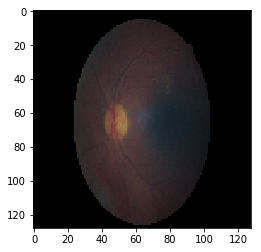

In [19]:
plt.imshow(x_train[1000]/255)
plt.show()

Its important to split the whole dataset into training and validation dataset apart from testing dataset which we have seperately.

In [20]:
x_valid = []
y_valid = []

In [21]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

Now we will define the model >>
The model has 2 convolutional leyers, 2 max pooling layes, image flattening layer and a dence layer
Models in Keras/TF come in 2 forms - Sequential (model = Sequential()) or using Funtional API
Below code is using Funtional API which is usually used for complex models, i will leave the light weight Sequential() model in comments

In [22]:
y_train_raw = np.array(Y_train)

In [23]:
x_train_raw = np.array(X_train)

In [24]:
visible = Input(shape=(128,128,3))
conv6 = Conv2D(16, kernel_size=(6,6), activation='relu')(visible)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
#bat1 = BatchNormalization(axis = 1)(pool1)

conv2 = Conv2D(64, kernel_size=(4,4), activation='relu')(pool3)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, kernel_size=(2,2), activation='relu')(pool2)
conv4 = Conv2D(128, kernel_size=(2,2), activation='relu')(conv3)
conv5 = Conv2D(256, kernel_size=(2,2), activation='relu')(conv4)

#pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(conv5)
hidden1 = Dense(128, activation='relu')(flat)
drop1 = Dropout(0.2)(hidden1)

hidden2 = Dense(64, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)
output = Dense(5, activation='sigmoid')(drop2)
#output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=visible, outputs=output)

If you are planning to run less complex model run below lines, i will suggess to use a trasfer learning technique if you are planning to use below model for better results

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(786, 786, 3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

There are variety of optimizers available >> https://keras.io/optimizers/
More about loss functions >> https://keras.io/losses/
Metrics >> https://keras.io/metrics/

In [25]:
from keras import optimizers
opt = optimizers.adam(lr=0.001, decay=0.0)

In [26]:
model.compile(optimizer= opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Lets convert the array into a numpy array, this might take some time

This is how the layers are stack on top of each other

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 123, 16)      1744      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       32896     
__________

This command will actually train the model.
Even with less number of images, you might come accross 'Insufficient memory error' or 'Kernel restart error'

In [28]:
with tf.device('/device:GPU:0'):    
    model.fit(x_train_raw, y_train_raw, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
1513/1513 [==============================] - 5s 4ms/step - loss: 1.8595 - acc: 0.6966
Epoch 2/5
1513/1513 [==============================] - 2s 1ms/step - loss: 1.7839 - acc: 0.7343
Epoch 3/5
1513/1513 [==============================] - 2s 1ms/step - loss: 1.8710 - acc: 0.7343
Epoch 4/5
1513/1513 [==============================] - 2s 1ms/step - loss: 2.1282 - acc: 0.7350
Epoch 5/5
1513/1513 [==============================] - 2s 1ms/step - loss: 2.4607 - acc: 0.7350


In [29]:
x_valid_raw = np.array(X_valid)

In [30]:
y_valid_raw = np.array(Y_valid)

Once the model is trained, we need to evaluate the performance of the model with all validation dataset.

In [31]:
test_loss, test_acc = model.evaluate(x_valid_raw, y_valid_raw)

169/169 [==============================] - 0s 2ms/step


In [32]:
test_loss

2.338465699077358

In [33]:
test_acc

0.739644971824962

In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
     print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
     print("Please install GPU version of TF")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Default GPU Device: /device:GPU:0
